Madhubhashana I.K.

IT19106502

Import and Install all dependancies


In [23]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

Define bactch size epochs etc..

In [24]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

mount the drive withnotebook and import dataset
Dataset source - kaggle web site 

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/mammals",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 189 files belonging to 2 classes.


display classes names

In [26]:
class_names = dataset.class_names
class_names

['elephant', 'goat']

Added Validation to check if ther any file with compatible issues 

In [27]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/mammals"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [28]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0]


Display/visulaize the sample images in the data set
we can change the range value to change number of disply images

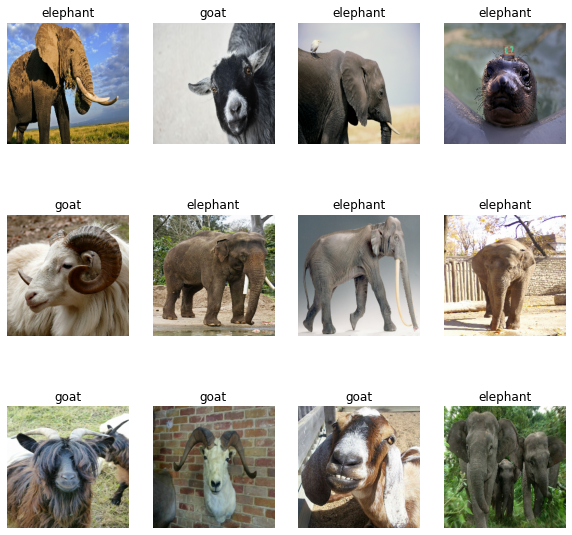

In [29]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Functionsfor split the data

In [30]:
len(dataset)

6

In [31]:
train_size = 0.8
len(dataset)*train_size


4.800000000000001

In [32]:
train_ds = dataset.take(54)
len(train_ds)


6

In [33]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [34]:
val_size=0.1
len(dataset)*val_size

0.6000000000000001

In [35]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [36]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)


4

In [40]:
len(val_ds)

0

In [41]:
len(test_ds)

2

shuffle and prefetch dataset

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Build CCNN model

resize and rescale images

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pre proccesing - Data Augmentation & Apply it to the train dataset

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Added layer Architechture

In [48]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

Display Summery of the layers

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model


In [50]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
4/4 [==============================] - 24s 5s/step - loss: 0.6916 - accuracy: 0.5040
Epoch 2/50
4/4 [==============================] - 16s 4s/step - loss: 0.6850 - accuracy: 0.4880
Epoch 3/50
4/4 [==============================] - 15s 4s/step - loss: 0.6346 - accuracy: 0.7040
Epoch 4/50
4/4 [==============================] - 15s 4s/step - loss: 0.6305 - accuracy: 0.6400
Epoch 5/50
4/4 [==============================] - 15s 4s/step - loss: 0.5601 - accuracy: 0.7120
Epoch 6/50
4/4 [==============================] - 15s 4s/step - loss: 0.5115 - accuracy: 0.8080
Epoch 7/50
4/4 [==============================] - 15s 4s/step - loss: 0.4811 - accuracy: 0.7520
Epoch 8/50
4/4 [==============================] - 15s 4s/step - loss: 0.4434 - accuracy: 0.7840
Epoch 9/50
4/4 [==============================] - 15s 4s/step - loss: 0.4142 - accuracy: 0.8000
Epoch 10/50
4/4 [==============================] - 15s 4s/step - loss: 0.3980 - accuracy: 0.8320
Epoch 11/50
4/4 [======================

In [52]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 7s 993ms/step - loss: 0.6941 - accuracy: 0.8281


In [53]:
scores

[0.6941239833831787, 0.828125]

In [54]:
history

In [55]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 4}

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [57]:
type(history.history['loss'])

list

In [58]:
len(history.history['loss'])

50

In [59]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6915680170059204,
 0.684964656829834,
 0.6346154808998108,
 0.6304605007171631,
 0.5600617527961731]

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

KeyError: ignored

Display Accuracy using plot

NameError: ignored

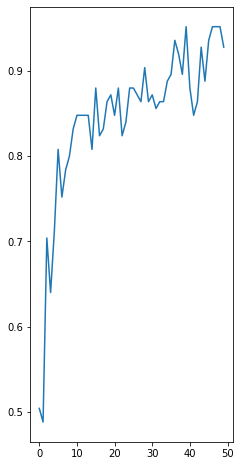

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: goat
1/1 [==============================] - 1s 1s/step
predicted label: goat


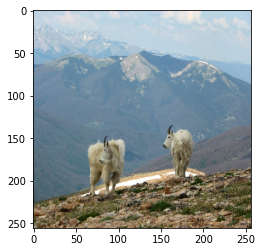

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 49ms/step


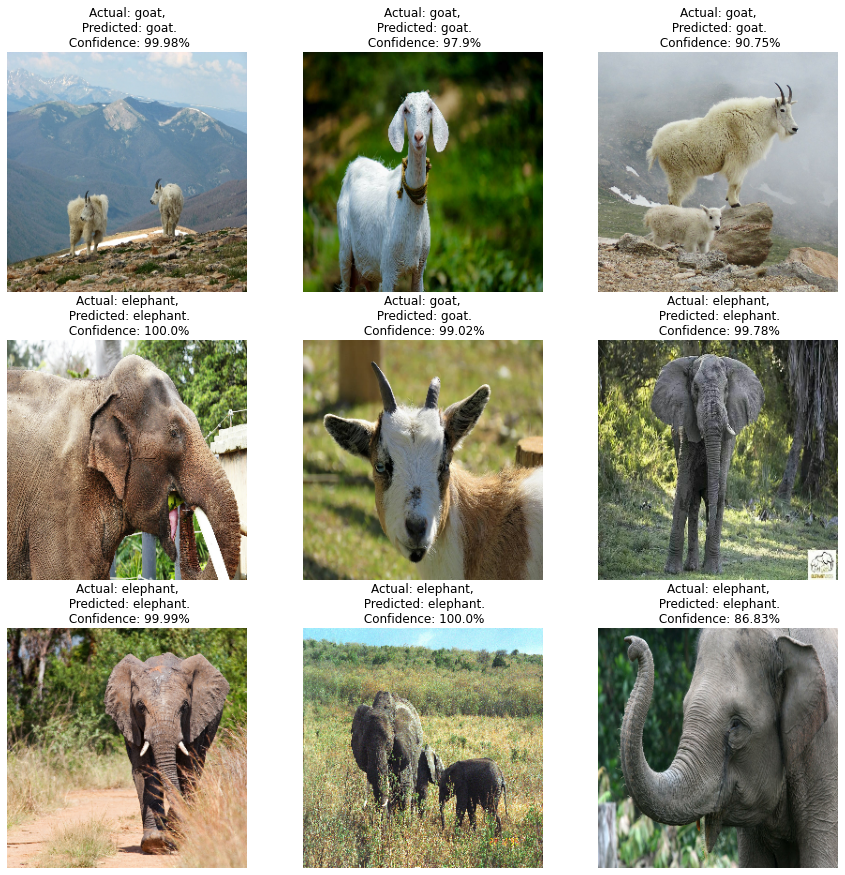

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [74]:
import os
model_version=max([int(i) for i in os.listdir("/models") + [0]])+1
model.save(f"/models/{model_version}")

FileNotFoundError: ignored

In [73]:
model.save("../animal.h5")